In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_

from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from PIL import Image

import shutil

In [2]:
seed = 142
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
class Imagedataset(Dataset):
    def __init__(self, data_dir, transform=None):
        monet_dir = os.path.join(data_dir, 'monet_jpg')
        photo_dir = os.path.join(data_dir, 'photo_jpg')
        self.monet_files = [os.path.join(monet_dir, x) for x in os.listdir(monet_dir)]
        self.photo_files = [os.path.join(photo_dir, x) for x in os.listdir(photo_dir)]
        self.transform = transform
    def __len__(self):
        return max(len(self.monet_files), len(self.photo_files))
    def __getitem__(self, idx):
        monet_idx = idx % len(self.monet_files)
        photo_idx = idx % len(self.photo_files)
        monet_img = Image.open(self.monet_files[monet_idx])
        photo_img = Image.open(self.photo_files[photo_idx])
        if self.transform:
            monet_img = self.transform(monet_img)
            photo_img = self.transform(photo_img)
        return monet_img, photo_img

In [4]:
data_dir = './'
batch_size = 5

In [5]:
transforms_ = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
dataloader = DataLoader(Imagedataset(data_dir, transforms_), batch_size=batch_size, shuffle=True, num_workers=4)

In [6]:
def unnorm(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

In [7]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0, transpose=False, use_leaky=True, use_dropout=False, normalize=True):
        super(ConvBlock, self).__init__()
        self.block = []
        if transpose:
            self.block += [nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, output_padding=1)]
        else:
            self.block += [nn.Conv2d(in_channels, out_channels,
                                     kernel_size, stride, padding, bias=True)]

        if normalize:
            self.block += [nn.InstanceNorm2d(out_channels)]
        if use_dropout:
            self.block += [nn.Dropout(0.5)]
        if use_leaky:
            self.block += [nn.LeakyReLU(0.2, inplace=True)]
        else:
            self.block += [nn.ReLU(inplace=True)]
        self.block = nn.Sequential(*self.block)
    def forward(self, x):
        return self.block(x)

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            ConvBlock(channels, channels, kernel_size=3,use_leaky=False, use_dropout=False),
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, kernel_size=3),
            nn.InstanceNorm2d(channels)
        )
    def forward(self, x):
        return x + self.block(x)

In [9]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels, n_residual_blocks=9):
        super(Generator, self).__init__()
        self.initial = [
            nn.ReflectionPad2d(in_channels),
            ConvBlock(in_channels, 64, kernel_size=2 *
                      in_channels+1, use_leaky=False)
        ]
        self.initial = nn.Sequential(*self.initial)

        self.down = [
            ConvBlock(64, 128, kernel_size=3, stride=2,
                      padding=1, use_leaky=False),
            ConvBlock(128, 256, kernel_size=3, stride=2,
                      padding=1, use_leaky=False)
        ]
        self.down = nn.Sequential(*self.down)

        self.transform = [ResidualBlock(256) for _ in range(n_residual_blocks)]
        self.transform = nn.Sequential(*self.transform)

        self.up = [
            ConvBlock(256, 128, kernel_size=3, stride=2,
                      padding=1, transpose=True, use_leaky=False),
            ConvBlock(128, 64, kernel_size=3, stride=2,
                      padding=1, transpose=True, use_leaky=False)
        ]
        self.up = nn.Sequential(*self.up)

        self.out = nn.Sequential(
            
                nn.ReplicationPad2d(3),
                nn.Conv2d(64, out_channels, kernel_size=2*out_channels+1),
                nn.Tanh()
            
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.down(x)
        x = self.up(x)
        x = self.out(x)
        return x


In [10]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            ConvBlock(in_channels, 64, kernel_size=4, stride=2, padding=1, use_leaky=True, use_dropout=False, normalize=False),
            ConvBlock(64, 128, kernel_size=4, stride=2, padding=1),
            ConvBlock(128, 256, kernel_size=4, stride=2, padding=1),
            ConvBlock(256, 512, kernel_size=4, stride=2, padding=1),
            ConvBlock(512, 1, kernel_size=4, stride=1, padding=1)
        )
    def forward(self, x):
        return self.model(x)

In [11]:
generator_monetToPhoto = Generator(3, 3, 9).to(device)
generator_photoToMonet = Generator(3, 3, 9).to(device)
discriminator_monet = Discriminator(3).to(device)
discriminator_photo = Discriminator(3).to(device)

In [12]:
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

In [13]:
lr = 2e-4
b1 = 0.5
b2 = 0.999

In [14]:
optim_generator = torch.optim.Adam(
    list(generator_monetToPhoto.parameters()) + list(generator_photoToMonet.parameters()), lr=lr, betas=(b1, b2))
optim_discriminator = torch.optim.Adam(
    list(discriminator_monet.parameters()) + list(discriminator_photo.parameters()), lr=lr, betas=(b1, b2))


In [15]:
num_epochs = 80
decay_epoch = 25

lr_scheduler_step = lambda epoch: 1.0 - max(0, epoch - num_epochs) / float(num_epochs + 1)
lr_scheduler_generator = torch.optim.lr_scheduler.LambdaLR(optim_generator, lr_lambda=lr_scheduler_step)
lr_scheduler_discriminator = torch.optim.lr_scheduler.LambdaLR(optim_discriminator, lr_lambda=lr_scheduler_step)

In [16]:
class History:
    def __init__(self):
        self.generators_loss = []
        self.discriminators_loss = []
    def update(self, generator_loss, discriminator_loss):
        self.generators_loss.append(generator_loss)
        self.discriminators_loss.append(discriminator_loss)
    def show(self):
        plt.plot(self.generators_loss, label='Generator')
        plt.plot(self.discriminators_loss, label='Discriminator')
        plt.legend()
        plt.show()

In [17]:
class Buffer:
    def __init__(self, max_images=50):
        self.max_images = max_images
        self.images = []
    
    def update(self, images):
        images = images.detach().cpu().numpy()
        for image in images:
            if len(self.images) < self.max_images:
                self.images.append(image)
            else:
                if np.random.rand() > 0.5:
                    i = np.random.randint(0, self.max_images)
                    self.images[i] = image
    
    def sample(self, num_images):
        samples = np.array([self.images[np.random.randint(0, len(self.images))] for _ in range(num_images)])
        return torch.tensor(samples)

In [18]:
def update_requires_grad(models, requires_grad=True):
    for model in models:
        for param in model.parameters():
            param.requires_grad = requires_grad

In [19]:
history = History()
buffer_monet = Buffer()
buffer_photo = Buffer()

  0%|          | 0/1408 [00:00<?, ?it/s]

Epoch 0 | Generator loss: 5.134443599053404 | Discriminator loss: 0.3020981524816968


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

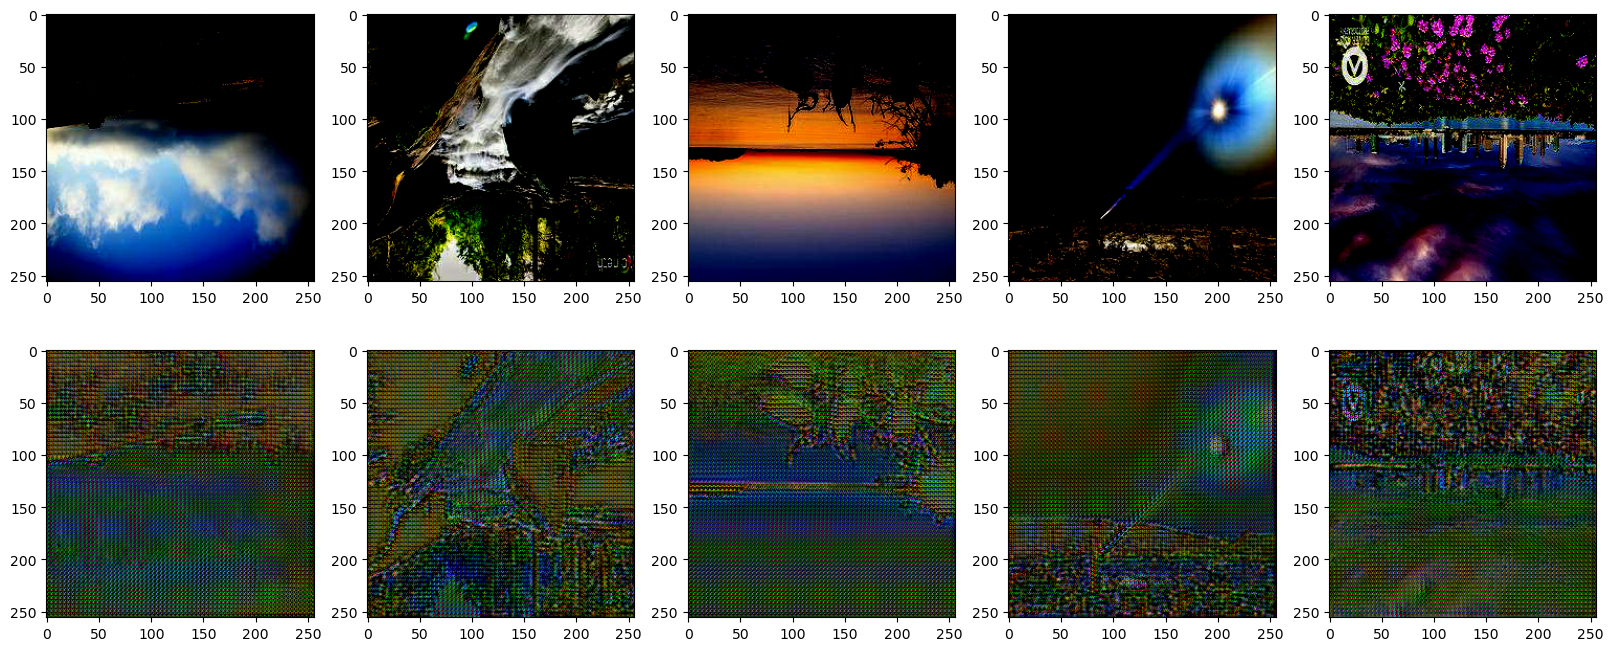

  0%|          | 0/1408 [00:00<?, ?it/s]

Epoch 1 | Generator loss: 4.116772141138261 | Discriminator loss: 0.28977642130022024


  0%|          | 0/1408 [00:00<?, ?it/s]

Epoch 2 | Generator loss: 3.7443070379509167 | Discriminator loss: 0.28949008424851025


  0%|          | 0/1408 [00:00<?, ?it/s]

Epoch 3 | Generator loss: 3.4895798553797333 | Discriminator loss: 0.28753380064683204


  0%|          | 0/1408 [00:00<?, ?it/s]

Epoch 4 | Generator loss: 3.3006596590646287 | Discriminator loss: 0.28810848903164943


  0%|          | 0/1408 [00:00<?, ?it/s]

Epoch 5 | Generator loss: 3.159611777656458 | Discriminator loss: 0.2900890677066689


  0%|          | 0/1408 [00:00<?, ?it/s]

Epoch 6 | Generator loss: 3.052084387534044 | Discriminator loss: 0.28928030510856345


  0%|          | 0/1408 [00:00<?, ?it/s]

Epoch 7 | Generator loss: 2.9626900367438793 | Discriminator loss: 0.29132825699211523


  0%|          | 0/1408 [00:00<?, ?it/s]

Epoch 8 | Generator loss: 2.8756463630971583 | Discriminator loss: 0.29116484289988875


  0%|          | 0/1408 [00:00<?, ?it/s]

Epoch 9 | Generator loss: 2.8133030603216453 | Discriminator loss: 0.29082236237908626


  0%|          | 0/1408 [00:00<?, ?it/s]

Epoch 10 | Generator loss: 2.7435181413523178 | Discriminator loss: 0.29274006719192996


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

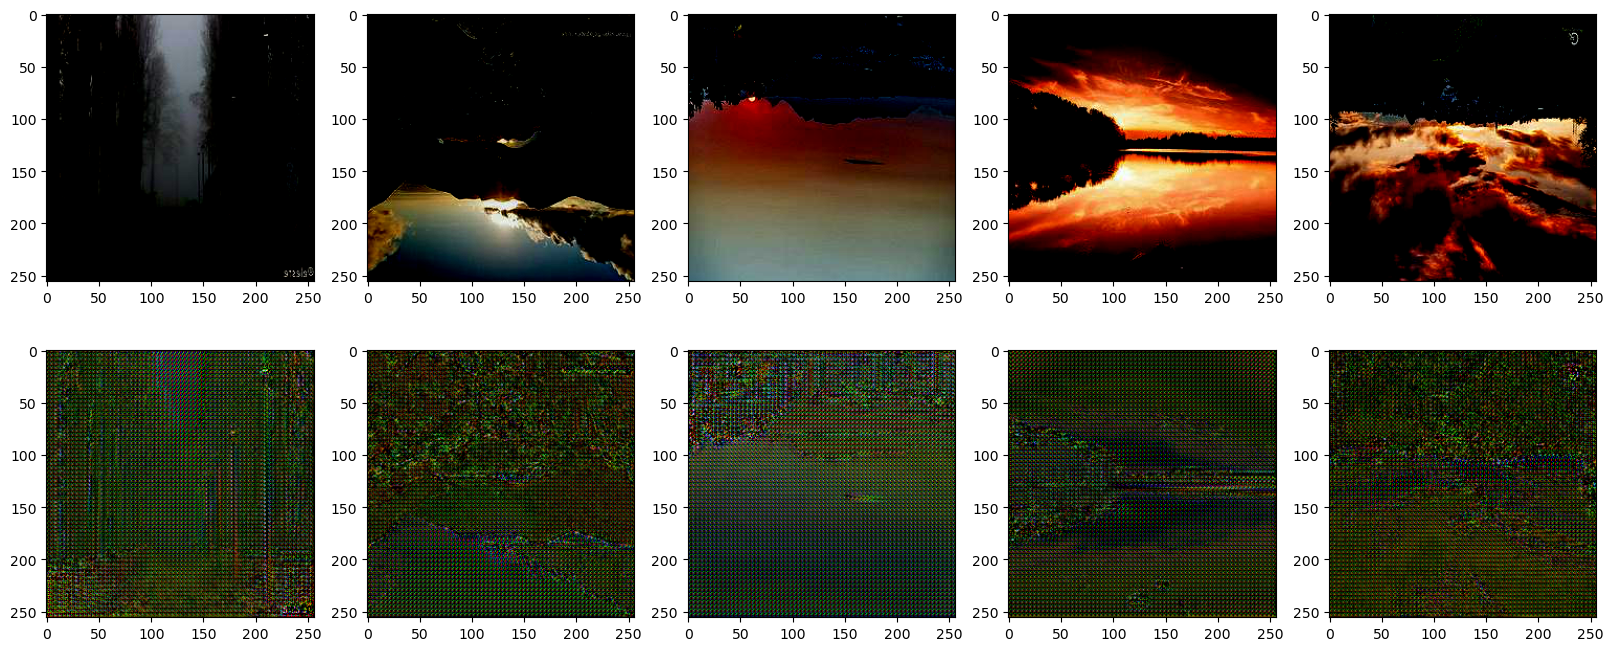

  0%|          | 0/1408 [00:00<?, ?it/s]

Epoch 11 | Generator loss: 2.685108153318817 | Discriminator loss: 0.29219364163211803


  0%|          | 0/1408 [00:00<?, ?it/s]

Epoch 12 | Generator loss: 2.6415308028120887 | Discriminator loss: 0.29215939332392404


  0%|          | 0/1408 [00:00<?, ?it/s]

Epoch 13 | Generator loss: 2.586186224086718 | Discriminator loss: 0.29327528400939296


  0%|          | 0/1408 [00:00<?, ?it/s]

Epoch 14 | Generator loss: 2.5482458534057844 | Discriminator loss: 0.2949121992146088


  0%|          | 0/1408 [00:00<?, ?it/s]

Epoch 15 | Generator loss: 2.503518670458685 | Discriminator loss: 0.2953020162795755


  0%|          | 0/1408 [00:00<?, ?it/s]

Epoch 16 | Generator loss: 2.4646493799307128 | Discriminator loss: 0.29646406324834307


  0%|          | 0/1408 [00:00<?, ?it/s]

Epoch 17 | Generator loss: 2.433674586513503 | Discriminator loss: 0.2963265349707482


  0%|          | 0/1408 [00:00<?, ?it/s]

Epoch 18 | Generator loss: 2.413194122470238 | Discriminator loss: 0.2980627800464969


  0%|          | 0/1408 [00:00<?, ?it/s]

Epoch 19 | Generator loss: 2.369378004053777 | Discriminator loss: 0.2983006115748801


  0%|          | 0/1408 [00:00<?, ?it/s]

Epoch 20 | Generator loss: 2.3447812056507575 | Discriminator loss: 0.2989749156827615


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

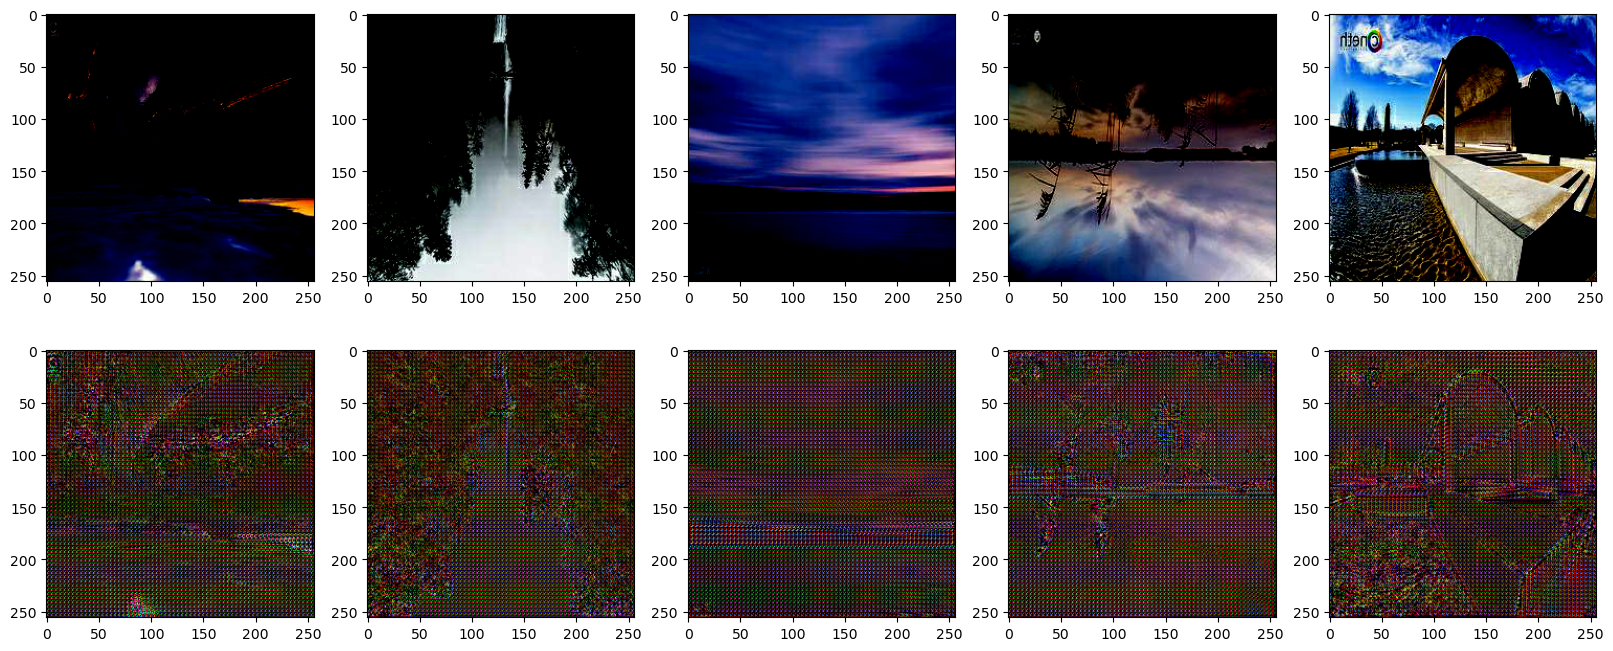

  0%|          | 0/1408 [00:00<?, ?it/s]

Epoch 21 | Generator loss: 2.3134904668920417 | Discriminator loss: 0.2995391506490044


  0%|          | 0/1408 [00:00<?, ?it/s]

Epoch 22 | Generator loss: 2.2949759170243684 | Discriminator loss: 0.299438406416977


  0%|          | 0/1408 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [20]:
for epoch in range(num_epochs):
    avg_generator_loss = 0
    avg_discriminator_loss = 0
    for i, (real_monet, real_photo) in enumerate(tqdm(dataloader, leave=False, total=len(dataloader))):
        real_monet, real_photo = real_monet.to(device), real_photo.to(device)
        update_requires_grad([discriminator_monet, discriminator_photo], False)
        update_requires_grad([generator_monetToPhoto, generator_photoToMonet], True)
        optim_generator.zero_grad()
        
        fake_photo = generator_monetToPhoto(real_monet)
        fake_monet = generator_photoToMonet(real_photo)
        
        cycle_photo = generator_monetToPhoto(fake_monet)
        cycle_monet = generator_photoToMonet(fake_photo)
        
        identity_photo = generator_monetToPhoto(real_photo)
        identity_monet = generator_photoToMonet(real_monet)
        
        buffer_monet.update(fake_monet)
        buffer_photo.update(fake_photo)
        
        discriminator_output_photo = discriminator_photo(real_photo)
        discriminator_output_monet = discriminator_monet(real_monet)
        
        labels_real = torch.ones_like(discriminator_output_photo).to(device)
        labels_fake = torch.zeros_like(discriminator_output_photo).to(device)
        
        loss_GAN_monetTophoto = criterion_GAN(discriminator_output_photo, labels_real)
        loss_GAN_photoTomonet = criterion_GAN(discriminator_output_monet, labels_real)
        loss_GAN = (loss_GAN_monetTophoto + loss_GAN_photoTomonet) / 2
        
        loss_cycle_photo = criterion_cycle(cycle_photo, real_photo)
        loss_cycle_monet = criterion_cycle(cycle_monet, real_monet)
        loss_identity = (loss_cycle_monet + loss_cycle_photo) / 2
        
        loss_generators_total = loss_GAN + 10 * loss_cycle_monet + 10 * loss_cycle_photo + 5 * loss_identity
        loss_generators_total.backward()
        optim_generator.step()
        
        clip_grad_norm_(generator_monetToPhoto.parameters(), 100)
        clip_grad_norm_(generator_photoToMonet.parameters(), 100)
        
        update_requires_grad([discriminator_monet, discriminator_photo], True)
        update_requires_grad([generator_monetToPhoto, generator_photoToMonet], False)
        
        optim_discriminator.zero_grad()
        
        fake_photo = buffer_photo.sample(real_photo.shape[0]).to(device)
        fake_monet = buffer_monet.sample(real_monet.shape[0]).to(device)
        
        thresold = min(1, 0.85+(1-0.85)*epoch/(num_epochs // 2))
        noisy_labels_real = (torch.rand_like(labels_real) * (1 - thresold) + thresold).float().to(device)
        
        loss_real_photo = criterion_GAN(discriminator_photo(real_photo), noisy_labels_real)
        loss_fake_photo = criterion_GAN(discriminator_photo(fake_photo), labels_fake)
        loss_photo = (loss_real_photo + loss_fake_photo) / 2
        
        loss_real_monet = criterion_GAN(discriminator_monet(real_monet), noisy_labels_real)
        loss_fake_moent = criterion_GAN(discriminator_monet(fake_monet), labels_fake)
        loss_monet = (loss_real_monet + loss_fake_moent) / 2
        
        loss_discriminator_total = (loss_photo + loss_monet) / 2
        loss_discriminator_total.backward()
        optim_discriminator.step()
        
        clip_grad_norm_(discriminator_monet.parameters(), 100)
        clip_grad_norm_(discriminator_photo.parameters(), 100)
        
        avg_discriminator_loss += loss_discriminator_total.item()
        avg_generator_loss += loss_generators_total.item()
    avg_discriminator_loss /= len(dataloader)
    avg_generator_loss /= len(dataloader)
    history.update(avg_generator_loss, avg_discriminator_loss)
    print(f'Epoch {epoch} | Generator loss: {avg_generator_loss} | Discriminator loss: {avg_discriminator_loss}')
    if epoch % 10 == 0:
        torch.save(generator_monetToPhoto.state_dict(), f'generator_monetToPhoto_{epoch}.pth')
        torch.save(generator_photoToMonet.state_dict(), f'generator_photoToMonet_{epoch}.pth')
        torch.save(discriminator_monet.state_dict(), f'discriminator_monet_{epoch}.pth')
        torch.save(discriminator_photo.state_dict(), f'discriminator_photo_{epoch}.pth')
        _, sampleRealPhoto = next(iter(dataloader))
        sampleFakeMonet = generator_photoToMonet(sampleRealPhoto.to(device))
        num_photo = 5
        plt.figure(figsize=(20, 8))
        for k in range(num_photo):
            plt.subplot(2, num_photo, k+1)
            plt.imshow(sampleRealPhoto[k].permute(1, 2, 0))
            plt.subplot(2, num_photo, k+1+num_photo)
            plt.imshow(sampleFakeMonet[k].detach().cpu().permute(1, 2, 0))
        plt.show()
    lr_scheduler_generator.step()
    lr_scheduler_discriminator.step()